In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 23.2 MB/s 


In [ ]:
!unzip -q ../gdrive/MyDrive/ANNDL/Homework1/training_dataset_homework1.zip 

In [ ]:
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
import os
import random

!pip install split-folders

import splitfolders
dataset_dir = 'splitted'

splitfolders.ratio('training_data_final', output=dataset_dir, seed=seed, ratio=(.75, .15, .1), group_prefix=None) # default values

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import shutil
size = 550
og_dataset = 'splitted/train'
for item in os.listdir(og_dataset):
  class_path = os.path.join(og_dataset, item)
  while (len(os.listdir(class_path)) < size):
    if (len(os.listdir(class_path)) * 2 < size):
      for elem in os.listdir(class_path):
        shutil.copy2(os.path.join(class_path,elem),os.path.join(class_path,'copy_' + elem))
    else:
      elem = random.choice(os.listdir(class_path))
      shutil.copy2(os.path.join(class_path,elem),os.path.join(class_path,'copy_' + elem))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

category_names = sorted(os.listdir(og_dataset))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = og_dataset + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per Species:")

In [ ]:
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Plot example images from dataset
labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//3
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,2*num_col))
for i in range(len(labels)):
  class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
  class_img = class_imgs[0]
  img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
  #print(np.array(img))
  ax = axes[i//num_col, i%num_col]
  ax.imshow(np.array(img))
  ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=10,
                                        brightness_range=[0.5,1.8],
                                        height_shift_range=0.3,
                                        width_shift_range=0.3,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        preprocessing_function = 1./255
                                        ) 
aug_valid_data_gen = ImageDataGenerator(
                                    preprocessing_function = 1./255
                                    )
test_data_gen = ImageDataGenerator(
                                   preprocessing_function = 1./255
                                   )

In [ ]:

batch_size = 8

aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)


aug_valid_gen = aug_valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None,
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             shuffle=False,
                                             seed=seed)

Found 4400 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


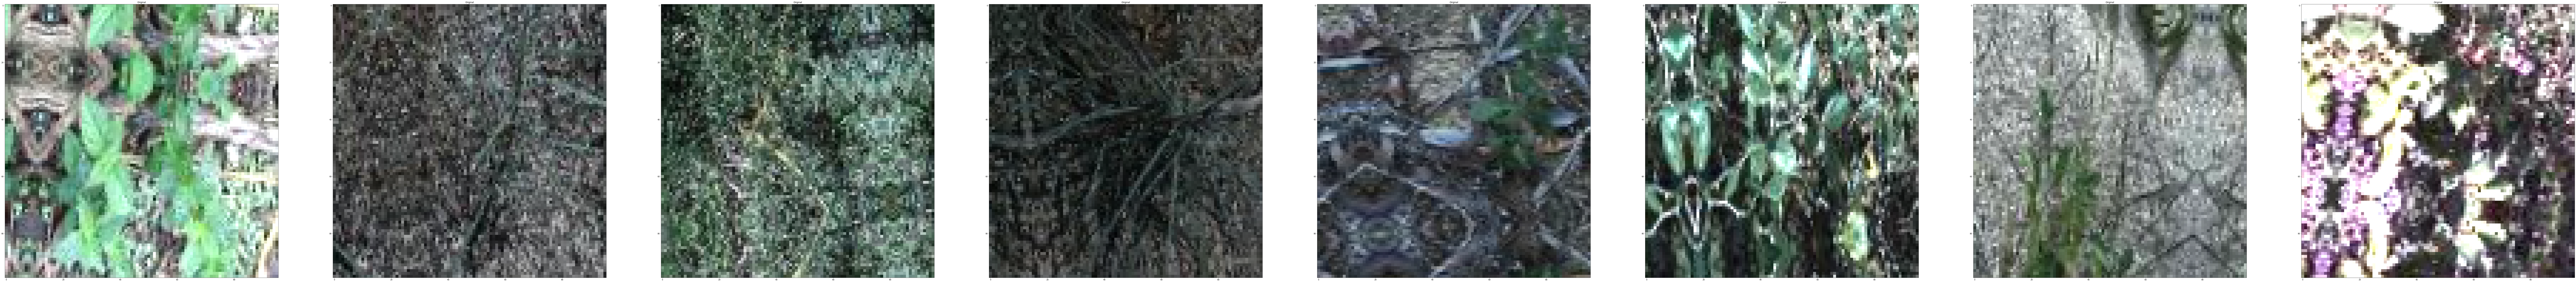

In [ ]:
image = next(aug_train_gen)[0]

fig, ax = plt.subplots(1, 8, figsize=(255, 255))
init = 0
for i in range(init, init+8):
  ax[i-init].imshow(np.array((image[i]+1)*127.5,np.uint8))
  ax[i-init].set_title('Original')

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('../gdrive/MyDrive/ANNDL/Homework1/ckptsFr')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)

  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Generating the model
Going in the output direction we decrease the dimension of a layer but we increase the channel number. In this way, we keep a big receptive field using fewer parameters.

In [ ]:
model = tf.keras.Sequential()

input_shape = [96, 96, 3]

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=input_shape))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(units=8, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 re_lu_15 (ReLU)             (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 re_lu_16 (ReLU)             (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                 

In [ ]:

loss = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'DoubleFilter')
#Loading from checkpoints, uncomment if needed
#tl_model.load_weights('')
# Train the model
tl_history = model.fit(
    #steps_per_epoch=len(aug_train_gen),
    x = aug_train_gen,
    epochs = 200,
    validation_data = aug_valid_gen,
    callbacks = tl_callbacks,
).history

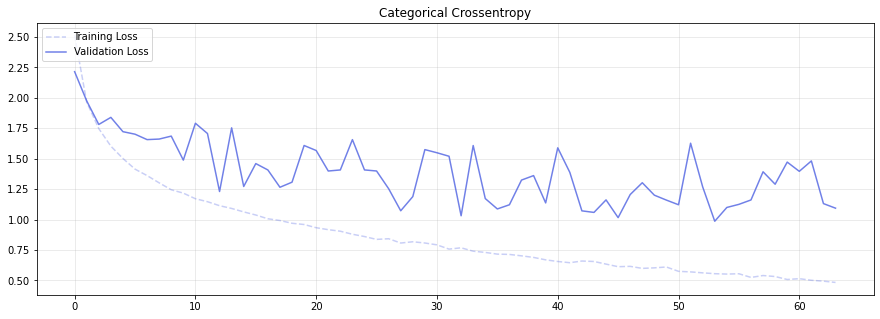

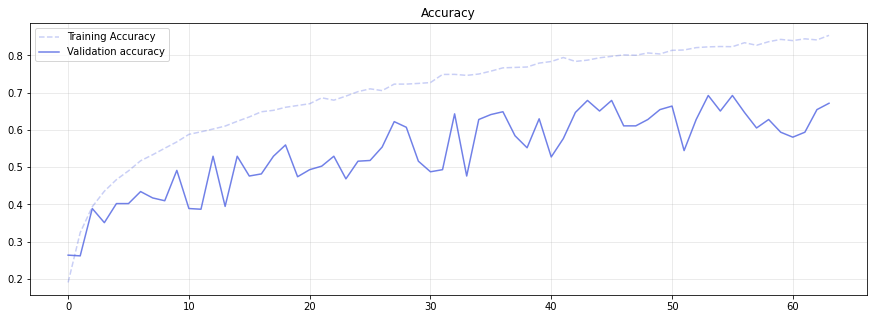

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save('/gdrive/My Drive/ANNDL/Challenge1/Models/Db')

In [ ]:
model_to_be_tested = tfk.models.load_model("/gdrive/My Drive/ANNDL/Challenge1/Models/Db")
model_to_be_tested_metrics = model_to_be_tested.evaluate(test_gen, return_dict=True)

46/46 [==============================] - 1s 9ms/step
[7 3 4 0 1 7 0 3 3 0 7 0 0 0 0 1 0 3 0 3 7 3 7 1 1 3 1 3 1 1 1 3 3 1 3 1 0
 6 1 1 1 3 1 1 1 1 6 1 1 1 1 7 3 1 1 1 1 7 1 1 1 1 1 3 1 7 1 1 1 1 1 1 1 1
 2 7 2 2 2 4 2 2 4 2 2 7 2 2 2 2 2 2 2 4 2 2 2 7 2 2 2 2 2 2 4 2 2 2 2 4 2
 0 2 2 2 2 2 4 0 4 4 2 2 2 2 2 3 4 3 3 3 3 3 3 2 3 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 0 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 2 2 4 4 4 2 4 4 4
 4 4 4 4 2 2 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 3 4 4 3 4 4 4 4 4 4 4
 4 4 2 4 4 4 4 4 4 4 3 5 5 5 5 5 3 5 5 3 5 5 5 5 5 6 2 6 5 5 4 5 5 3 1 3 6
 1 1 5 0 3 3 6 3 6 6 3 6 6 6 0 6 6 6 6 2 6 6 1 6 6 1 6 6 6 6 7 6 6 0 6 0 6
 7 6 6 6 6 1 6 0 1 6 1 6 6 6 3 7 7 0 7 7 0 7 0 7 4 7 7 0 3 7 7 4 7 7 7 6 7
 7 0 3 3 7 7 7 0 7 7 7 7 0 7 7 3 7 7 0 7 3 7 1 7 7 2 7 7]
Accuracy: 0.7064
Precision: 0.7156
Recall: 0.686
F1: 0.6903


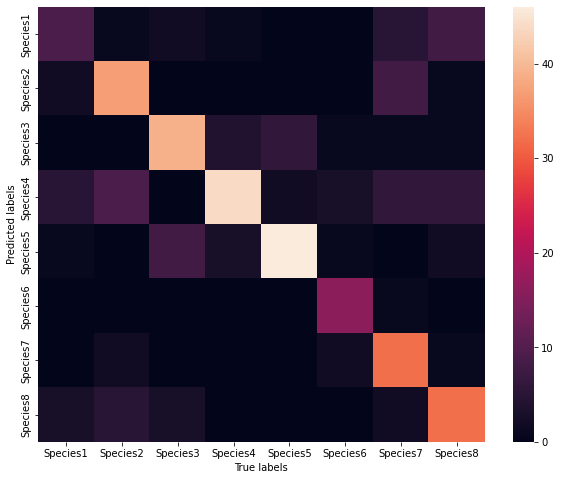

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes, normalize = True)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
import sklearn.metrics
print(sklearn.metrics.classification_report(test_gen.classes, predicted_classes,output_dict = False))

              precision    recall  f1-score   support

           0       0.35      0.45      0.39        20
           1       0.77      0.69      0.73        54
           2       0.75      0.75      0.75        52
           3       0.59      0.85      0.69        52
           4       0.75      0.85      0.80        54
           5       0.94      0.70      0.80        23
           6       0.86      0.58      0.70        55
           7       0.71      0.63      0.67        51

    accuracy                           0.71       361
   macro avg       0.72      0.69      0.69       361
weighted avg       0.73      0.71      0.71       361

